In [27]:
import time, datetime, psutil

from Source.metalayer import *
from Source.plotting import *
from Source.training import *
from Source.load_data import *

import warnings
import pickle

In [28]:
# Load hyperparameters
fname = "best_hparams.pkl"
with open(fname, 'rb') as file:
    best_hparams = pickle.load(file)

# Print hparams
print('\nBest hyperparameters:')
print(f'\tlearnig_rate: {best_hparams.learning_rate:.3e}')
print(f'\tT_max: {best_hparams.T_max}')
print(f'\tweight_decay: {best_hparams.weight_decay:.3e}')
print('\tn_layers: {}'.format(best_hparams.n_layers))
print('\thidden_channels: {}'.format(best_hparams.hidden_channels))


Best hyperparameters:
	learnig_rate: 6.374e-04
	T_max: 12
	weight_decay: 1.072e-05
	n_layers: 4
	hidden_channels: 8


In [3]:
# setting epochs

best_hparams.learning_rate = 0.000762
best_hparams.T_max = 30
best_hparams.weight_decay = 1e-8
best_hparams.n_epochs = 200

In [4]:
set_seed(73)
time_ini = time.time()
warnings.filterwarnings("ignore")

# Load data and create dataset
print('\n--- Creating dataset ---\n')
time_dataset = time.time()
dataset = create_dataset(best_hparams)
print("Dataset created. Time elapsed:", datetime.timedelta(seconds=time.time()-time_dataset))

# Number of input node features (1, mass)
node_features = dataset[0].x.shape[1]


--- Creating dataset ---

Total of halos in the dataset: 1090680 
Mean of 545.3 halos per simulation 
Std of 239.6 halos
number of halos in least massive graph: 63
Total of graphs: 2000
Mean of masscut  207371210544396.72 with std  71053941532760.34
Dataset created. Time elapsed: 0:02:11.796076


In [23]:
# Split dataset among training, validation and testing datasets
set_seed(73)
train_loader, valid_loader, test_loader = split_datasets(dataset)

# Size of the output of the GNN 
dim_out = 2 * best_hparams.pred_params # in our case is 2 as mean and variance

# Initialize model
model = GNN(node_features=node_features,
            n_layers=best_hparams.n_layers,
            hidden_channels=best_hparams.hidden_channels,
            linkradius=best_hparams.r_link,
            dim_out=dim_out)

model.to(device)

process = psutil.Process()
print(f"Memory being used (GB): {process.memory_info().rss/1.e9:.3f}")

Memory being used (GB): 1.426


In [26]:
# Train the net
set_seed(73)
print("\n--- Training ---\n")
train_losses, valid_losses, test_losses = training_routine(model, train_loader, valid_loader, test_loader, best_hparams, verbose=True)


--- Training ---

Validation loss decreased (1.00e+03 --> -4.31e+00).  Saving model ...
Epoch: 001, Train Loss: -2.81e+00, Validation Loss: -4.31e+00, Error: 3.16e-01
Validation loss decreased (-4.31e+00 --> -5.72e+00).  Saving model ...
Epoch: 002, Train Loss: -5.02e+00, Validation Loss: -5.72e+00, Error: 3.08e-01
Validation loss decreased (-5.72e+00 --> -6.70e+00).  Saving model ...
Epoch: 003, Train Loss: -6.12e+00, Validation Loss: -6.70e+00, Error: 2.82e-01
Validation loss decreased (-6.70e+00 --> -6.90e+00).  Saving model ...
Epoch: 004, Train Loss: -6.73e+00, Validation Loss: -6.90e+00, Error: 2.62e-01
Validation loss decreased (-6.90e+00 --> -7.55e+00).  Saving model ...
Epoch: 005, Train Loss: -7.34e+00, Validation Loss: -7.55e+00, Error: 2.36e-01
Validation loss decreased (-7.55e+00 --> -7.94e+00).  Saving model ...
Epoch: 006, Train Loss: -7.84e+00, Validation Loss: -7.94e+00, Error: 2.22e-01
Validation loss decreased (-7.94e+00 --> -8.12e+00).  Saving model ...
Epoch: 007,

KeyboardInterrupt: 

In [25]:
# Test the model
set_seed(73)
test_loss, rel_err, chi2 = test(test_loader, model, best_hparams)
print("Test Loss: {:.4f}, Relative error: {:.4f}, Chi2: {:.4f}".format(test_loss, rel_err, chi2))

Test Loss: 7.5230, Relative error: 2.2006, Chi2: 3.2659


In [51]:
print("Finished. Time elapsed:",datetime.timedelta(seconds=time.time()-time_ini))

Finished. Time elapsed: 0:12:18.379418


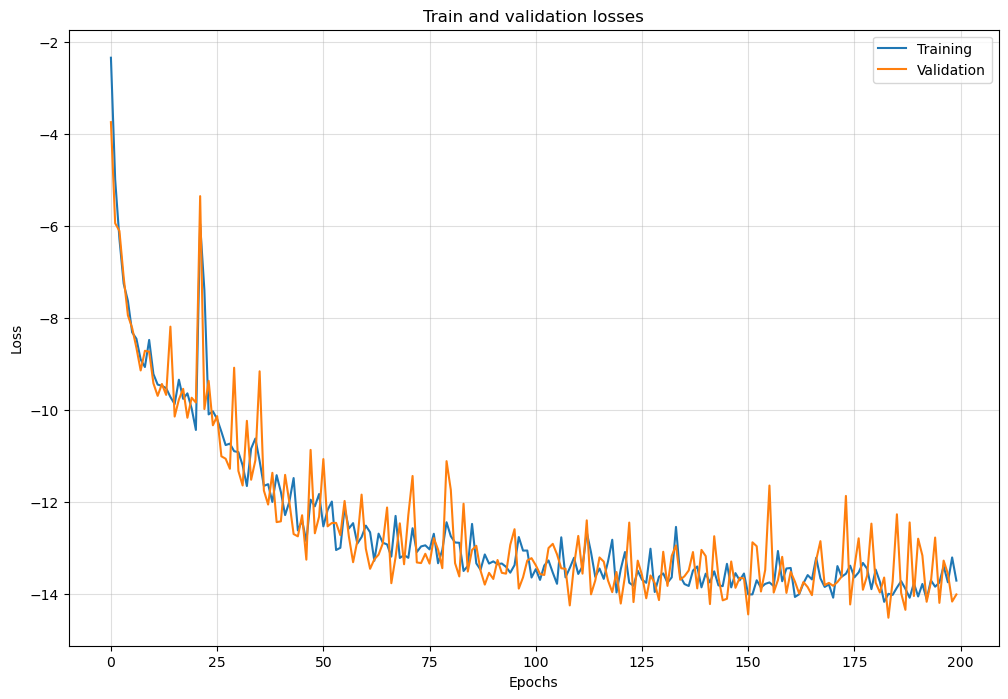

In [19]:
# Plot loss trends
plot_losses(train_losses, valid_losses, best_hparams, display = True)

R2: -23079.386
relative error: 45.910
A fraction of succeses of 0.000 at 1 sigma, 0.000 at 2 sigmas


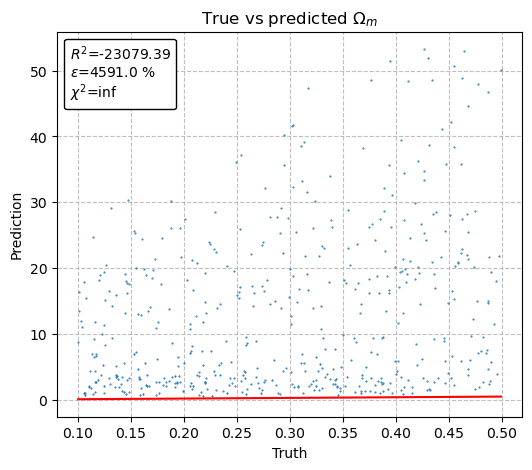

In [40]:
# Plot true vs predicted params
plot_out_true_scatter(best_hparams, "Om", display = True)
if best_hparams.pred_params==2:
    plot_out_true_scatter(best_hparams, "Sig", display = True)